In [1]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support,make_scorer


In [2]:
DATA_PATH = '../data/features/'

tran = pd.read_pickle(DATA_PATH + "T.pickle")
ntran = pd.read_pickle(DATA_PATH + "NT.pickle")

In [3]:
print(tran.shape[0]+ntran.shape[0])
print(tran[tran.index.get_level_values("copy_num")==0].shape[0]+ntran.shape[0])

62152
19462


In [4]:
ntran.tail()


,,Class,ObsCount,amplitude,beyond1st,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,kurtosis,...,poly3_t3,poly4_t1,poly4_t2,poly4_t3,poly4_t4,skew,small_kurtosis,std,stetson_j,stetson_k
ID,copy_num,,,,,,,,,,,,,,,,,,,,,
CataID3033022002583,0,non-transient,26,0.735,0.346154,0.127315,0.205024,0.305707,0.490865,0.867210,-0.863844,...,-4.381506e-11,0.000071,3.879196e-07,2.814693e-11,-8.962333e-14,-0.323662,-3.396739,0.418429,-0.030355,0.808361
CataID3047011003844,0,non-transient,155,1.095,0.296774,0.108153,0.190941,0.279280,0.445071,0.671028,1.114974,...,1.064017e-10,-0.000227,9.092593e-08,2.125542e-10,-1.177270e-13,0.360834,-3.059340,0.368006,0.116535,0.750544
CataID3047011003855,0,non-transient,170,1.085,0.258824,0.133967,0.212753,0.344202,0.523757,0.743903,1.874279,...,1.183648e-10,-0.000132,-1.976342e-07,8.569407e-11,3.401031e-14,0.007305,-3.053999,0.299632,0.063073,0.721548
CataID3039011002658,0,non-transient,246,0.470,0.146341,0.131166,0.199049,0.331865,0.473950,0.731653,32.978695,...,-1.966459e-12,-0.000029,3.271956e-08,2.593368e-12,-4.841826e-15,3.637046,-3.037088,0.071074,0.157681,0.724867
CataID3039010019034,0,non-transient,41,0.980,0.463415,0.103206,0.207452,0.250963,0.286646,0.777099,-0.396448,...,-1.044907e-10,0.000071,-4.613608e-07,-1.297451e-10,2.273128e-13,-0.439782,-3.238866,0.476747,-0.001186,0.728520


In [6]:
feats = np.array(tran.columns[2:])
print(len(feats))
print(feats)

30
['amplitude' 'beyond1st' 'flux_percentile_ratio_mid20'
 'flux_percentile_ratio_mid35' 'flux_percentile_ratio_mid50'
 'flux_percentile_ratio_mid65' 'flux_percentile_ratio_mid80' 'kurtosis'
 'max_slope' 'median_absolute_deviation' 'median_buffer_range_percentage'
 'pair_slope_trend' 'pair_slope_trend_last_30' 'percent_amplitude'
 'percent_difference_flux_percentile' 'poly1_t1' 'poly2_t1' 'poly2_t2'
 'poly3_t1' 'poly3_t2' 'poly3_t3' 'poly4_t1' 'poly4_t2' 'poly4_t3'
 'poly4_t4' 'skew' 'small_kurtosis' 'std' 'stetson_j' 'stetson_k']


In [7]:
alldf = pd.concat([tran,ntran])

# Without oversampling & not balancing test

In [4]:
noOversampling = alldf.copy()
noOversampling = noOversampling[noOversampling.index.get_level_values('copy_num')==0]

noOversampling = noOversampling.sample(frac=1)

## for binary case

In [90]:
noOversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', noOversampling.Class))

In [91]:
noOversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, noOversampling.Class))

In [10]:
def splitTrainTest(dataframe):
    test = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    test = test.set_index(["ID","copy_num"])

    train = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    train = train.set_index(["ID","copy_num"])
    for uClass in dataframe.Class.unique():
        classDf = dataframe[dataframe.Class == uClass]
        
        #ids unicos 
        ids = classDf.index.get_level_values('ID').unique()

        # escoger aleatoriamente 25% de los indices

        testInd = np.random.choice(ids, int(0.25*len(ids)),replace=False)

        #sacar dataframes
        test = pd.concat([test,classDf[classDf.index.get_level_values('ID').isin(testInd)]])
        
        train = pd.concat([train,classDf[~classDf.index.get_level_values('ID').isin(testInd)]])

    return train,test


In [11]:
def balance(df):
#     g = df.groupby('Class')
#     g=g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
    minNum = np.inf
    for classElem in df.Class.unique():
        numElems = len(df[df.Class==classElem])
        if(numElems<minNum):
            minNum=numElems
            
    ans = pd.DataFrame(columns = ["ID","copy_num"]+list(df.columns))
    ans = ans.set_index(["ID","copy_num"])
    for classElem in df.Class.unique():
        ans = pd.concat([ans,df[df.Class==classElem].sample(n=minNum)])
    return ans

In [94]:
recall_scores = []
iterations = 100
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(noOversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    
    
    clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
    clf.fit(all_train[feats], all_train.target)

    
    recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats])))

99.00%

Text(0.5,0,'Recall scores')

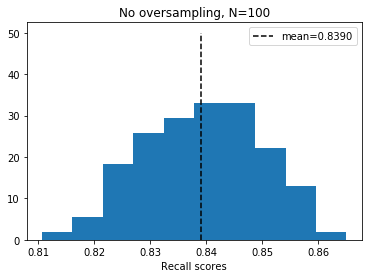

In [95]:
mean = np.mean(recall_scores)
plt.hist(recall_scores,density=True,bins=10)
plt.plot([mean,mean],[0,50],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("No oversampling, N=100")
plt.xlabel('Recall scores')

# WITH oversampling & not balancing test

## Binary case

In [150]:
oversampling = alldf.copy()
# oversampling = noOversampling[noOversampling.index.get_level_values('copy_num')==0]

oversampling = oversampling.sample(frac=1)



oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [154]:
recall_scores = []
iterations = 100
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    
    
    clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
    clf.fit(all_train[feats], all_train.target)
#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
    
    recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats])))

4.00%

KeyboardInterrupt: 

Text(0.5,0,'Recall scores')

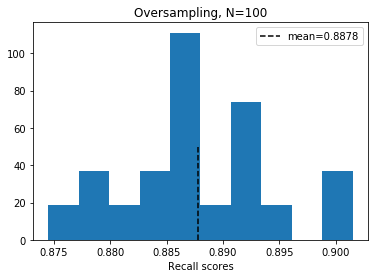

In [153]:
mean = np.mean(recall_scores)
plt.hist(recall_scores,density=True,bins=10)
plt.plot([mean,mean],[0,50],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("Oversampling, N=100")
plt.xlabel('Recall scores')

# WITH oversampling &  balancing test

In [10]:
oversampling = alldf.copy()
# oversampling = noOversampling[noOversampling.index.get_level_values('copy_num')==0]

oversampling = oversampling.sample(frac=1)



oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))
print(oversampling.shape)

(62152, 33)


In [12]:
recall_scores = []
precision_scores= []
iterations = 30
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
   

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
    
    # remove oversamples from test
    all_test = all_test[all_test.index.get_level_values('copy_num')==0]
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    
    #balance test
    all_test= balance(all_test)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')
    print(len(all_test)/(len(all_test)+len(all_train)))
    
    clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
    clf.fit(all_train[feats], all_train.target)

#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
    recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats]).astype(int)))
    precision_scores.append(precision_score(all_test.target,clf.predict(all_test[feats]).astype(int)))

0.00%0.08562028566843204
3.33%0.08562028566843204
6.67%0.08562028566843204
10.00%0.08562028566843204
13.33%0.08562028566843204
16.67%0.08562028566843204
20.00%0.08562028566843204
23.33%0.08562028566843204
26.67%0.08562028566843204
30.00%0.08562028566843204
33.33%0.08562028566843204
36.67%0.08562028566843204
40.00%0.08562028566843204
43.33%0.08562028566843204
46.67%0.08562028566843204


KeyboardInterrupt: 

0.9287359227585279


Text(0.5,0,'Recall scores')

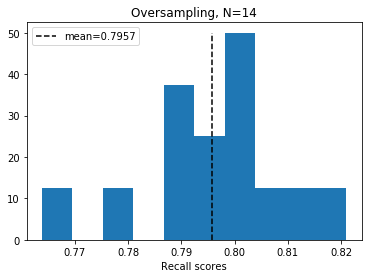

In [13]:
mean = np.mean(recall_scores)
meanp = np.mean(precision_scores)
print(meanp)
plt.hist(recall_scores,density=True,bins=10)
plt.plot([mean,mean],[0,50],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("Oversampling, N={}".format(int(len(recall_scores))))
plt.xlabel('Recall scores')

# WITHOUT oversampling &  balancing test

In [23]:
oversampling = alldf.copy()
print(oversampling.shape)
oversampling = oversampling[oversampling.index.get_level_values('copy_num')==0]
print(oversampling.shape)
oversampling = oversampling.sample(frac=1)



oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))


(62152, 32)
(19462, 32)


In [24]:
recall_scores = []
iterations = 100
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
   

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    # remove oversamples from test
    all_test = all_test[all_test.index.get_level_values('copy_num')==0]
    
    #balance test
    all_test= balance(all_test)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')
    
    
    clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
    clf.fit(all_train[feats], all_train.target)

#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
    recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats]).astype(int)))

99.00%

Text(0.5,0,'Recall scores')

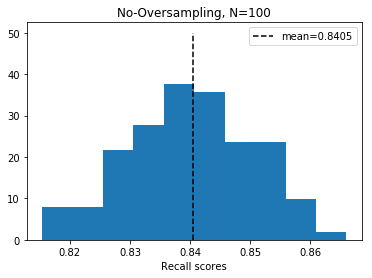

In [25]:
mean = np.mean(recall_scores)
plt.hist(recall_scores,density=True,bins=10)
plt.plot([mean,mean],[0,50],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("No-Oversampling, N=100")
plt.xlabel('Recall scores')

# --------
# With Grid Search

## Oversampling

In [14]:
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [15]:
oversampling = alldf.copy()
# oversampling = noOversampling[noOversampling.index.get_level_values('copy_num')==0]

oversampling = oversampling.sample(frac=1)



oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [16]:
recall_scores = []
iterations = 5
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
   

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    
    #balance test
    all_test= balance(all_test)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')
    
    model,params = rf()
    grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                               refit='f1_score', return_train_score=True,verbose=100)
    grid_search.fit(all_train[feats], all_train.target)
    # Copy classifier
    clf = grid_search
    
#     clf = RandomForestClassifier(n_estimators=200,random_state=0, class_weight='balanced')
#     clf.fit(all_train[feats], all_train.target)

#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
#     recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats]).astype(int)))

    scores = precision_recall_fscore_support(
            all_test.target, clf.predict(all_test[feats]), average='weighted')
#     print(scores)
    recall_scores.append(scores)

0.00%Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.9142681642681643, precision=0.9147244515460485, recall=0.9142681642681643, f1_score=0.9142445768546148, total=   9.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.9198701070738985, precision=0.9202312081687631, recall=0.9198701070738985, f1_score=0.9198528896417218, total=  12.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.9s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.916023166023166, precision=0.9165109761181435, recall=0.916023166023166, f1_score=0.9159985707858777, total=  40.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elap

KeyboardInterrupt: 

In [18]:
recall_scoresnp = np.array(recall_scores)
# print(recall_scoresnp[:,1])
print(recall_scoresnp)
print(np.mean(recall_scoresnp[:,0]))
print(np.mean(recall_scoresnp[:,1]))
print(np.mean(recall_scoresnp[:,2]))

[[0.9152955078335305 0.9139020537124802 0.9138297712906612 None]
 [0.9203328496344486 0.9196945760926803 0.9196640786588668 None]
 [0.9175665125134125 0.9160084254870985 0.9159300018291141 None]
 [0.9272494579128422 0.9269352290679305 0.9269217923740125 None]]
0.9201110819735584
0.9191350710900474
0.9190864110381636


Text(0.5,0,'Recall scores')

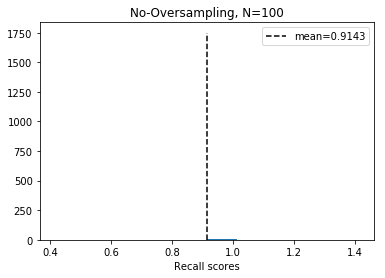

In [59]:
mean = np.mean(recall_scoresnp[:,1])
plt.hist(recall_scoresnp[:,1],density=True)
plt.plot([mean,mean],[0,1750],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("No-Oversampling, N=100")
plt.xlabel('Recall scores')

## No-oversampling

In [12]:
oversampling = alldf.copy()
oversampling = oversampling[oversampling.index.get_level_values('copy_num')==0]

oversampling = oversampling.sample(frac=1)



oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [13]:
recall_scores = []
iterations = 5
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
   

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    
    #balance test
    all_test= balance(all_test)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')
    
    model,params = rf()
    grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                               refit='f1_score', return_train_score=True,verbose=100)
    grid_search.fit(all_train[feats], all_train.target)
    # Copy classifier
    clf = grid_search
    
#     clf = RandomForestClassifier(n_estimators=200,random_state=0, class_weight='balanced')
#     clf.fit(all_train[feats], all_train.target)

#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
#     recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats]).astype(int)))

    scores = precision_recall_fscore_support(
            all_test.target, clf.predict(all_test[feats]), average='weighted')
#     print(scores)
    recall_scores.append(scores)

0.00%

NameError: name 'rf' is not defined

Text(0.5,0,'Recall scores')

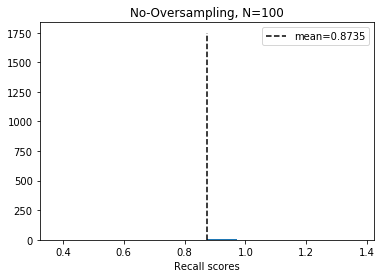

In [65]:
recall_scoresnp = np.array(recall_scores)
mean = np.mean(recall_scoresnp[:,1])
plt.hist(recall_scoresnp[:,1],density=True)
plt.plot([mean,mean],[0,1750],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("No-Oversampling, N=100")
plt.xlabel('Recall scores')

# 8-Class clasification

## No oversampling

In [18]:
labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare']
tran8 = tran.copy()
tran8.loc[~tran8.Class.isin(labels), ['Class']] = 'Other'
ntran8 = ntran.copy()




In [24]:
all8 = pd.concat([tran8,ntran8])

def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient']
    return labels.index(lab)

all8['target'] = list(map(lambda x: manualFact(x),all8['Class']))


oversampling = all8.copy()
oversampling = oversampling[oversampling.index.get_level_values('copy_num')==0]

oversampling = oversampling.sample(frac=1)

# oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

# oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [27]:
recall_scores = []
iterations = 100
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
   

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    # remove oversamples from test
    all_test = all_test[all_test.index.get_level_values('copy_num')==0]
    
    #balance test
    all_test= balance(all_test)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')
    
    
    clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
    clf.fit(all_train[feats], all_train.target)

#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
    recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats]).astype(int),average='weighted'))

99.00%

Text(0.5,0,'Recall scores')

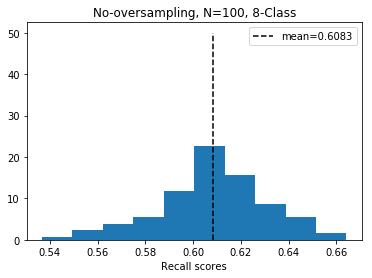

In [28]:
mean = np.mean(recall_scores)
plt.hist(recall_scores,density=True,bins=10)
plt.plot([mean,mean],[0,50],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("No-oversampling, N={}, 8-Class".format(int(len(recall_scores))))
plt.xlabel('Recall scores')

## with oversampling

In [14]:
labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare']
tran8 = tran.copy()
tran8.loc[~tran8.Class.isin(labels), ['Class']] = 'Other'
ntran8 = ntran.copy()




In [15]:
all8 = pd.concat([tran8,ntran8])

In [16]:
def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient']
    return labels.index(lab)

In [17]:
all8['target'] = list(map(lambda x: manualFact(x),all8['Class']))

In [18]:
oversampling = all8.copy()
# oversampling = oversampling[oversampling.index.get_level_values('copy_num')==0]

oversampling = oversampling.sample(frac=1)

# oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

# oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [20]:
recall_scores = []
precision_scores = []
iterations = 100
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
   

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    # remove oversamples from test
    all_test = all_test[all_test.index.get_level_values('copy_num')==0]
    
    #balance test
    all_test= balance(all_test)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')
    
    
    clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
    clf.fit(all_train[feats], all_train.target)

#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
    recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats]).astype(int),average='weighted'))
    precision_scores.append(precision_score(all_test.target,clf.predict(all_test[feats]).astype(int),average='weighted'))

20.00%

KeyboardInterrupt: 

0.6400805824636893


Text(0.5,0,'Recall scores')

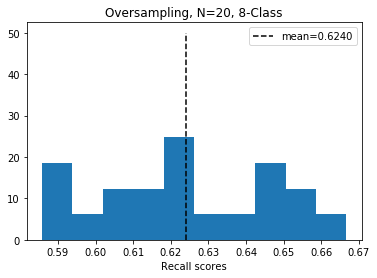

In [21]:
mean = np.mean(recall_scores)
meanp = np.mean(precision_scores)
print(meanp)
plt.hist(recall_scores,density=True,bins=10)
plt.plot([mean,mean],[0,50],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("Oversampling, N={}, 8-Class".format(int(len(recall_scores))))
plt.xlabel('Recall scores')

# With grid-search

## no-oversampling

In [19]:
labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare']
tran8 = tran.copy()
tran8.loc[~tran8.Class.isin(labels), ['Class']] = 'Other'
ntran8 = ntran.copy()




all8 = pd.concat([tran8,ntran8])

def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient']
    return labels.index(lab)

all8['target'] = list(map(lambda x: manualFact(x),all8['Class']))


oversampling = all8.copy()
oversampling = oversampling[oversampling.index.get_level_values('copy_num')==0]

oversampling = oversampling.sample(frac=1)

# oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

# oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [20]:
recall_scores = []
iterations = 5
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
   

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    
    #balance test
    all_test= balance(all_test)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')
    
    model,params = rf()
    grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                               refit='f1_score', return_train_score=True,verbose=100)
    grid_search.fit(all_train[feats], all_train.target)
    # Copy classifier
    clf = grid_search
    
#     clf = RandomForestClassifier(n_estimators=200,random_state=0, class_weight='balanced')
#     clf.fit(all_train[feats], all_train.target)

#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
#     recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats]).astype(int)))

    scores = precision_recall_fscore_support(
            all_test.target, clf.predict(all_test[feats]), average='weighted')
#     print(scores)
    recall_scores.append(scores)

0.00%Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.5961538461538461, precision=0.5942342426798449, recall=0.5961538461538461, f1_score=0.5902553640543882, total=   0.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.5961538461538461, precision=0.5961648575943373, recall=0.5961538461538461, f1_score=0.5908199362056352, total=   0.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.5833333333333334, precision=0.5845230475887748, recall=0.5833333333333334, f1_score=0.5791802413633167, total=   1.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | el

In [21]:
recall_scoresnp = np.array(recall_scores)
# print(recall_scoresnp[:,1])
print(recall_scoresnp)
print(np.mean(recall_scoresnp[:,0]))
print(np.mean(recall_scoresnp[:,1]))
print(np.mean(recall_scoresnp[:,2]))

[[0.592263094810602 0.5955882352941176 0.5896059460321981 None]
 [0.6280630397278087 0.6323529411764706 0.6289673068900327 None]
 [0.5912164424911183 0.5931372549019608 0.5892434848349312 None]
 [0.6239535559367974 0.6299019607843137 0.6232546848460983 None]
 [0.5918652156063229 0.5955882352941176 0.589796685468214 None]]
0.6054722697145298
0.6093137254901961
0.6041736216142948


Text(0.5,0,'Recall scores')

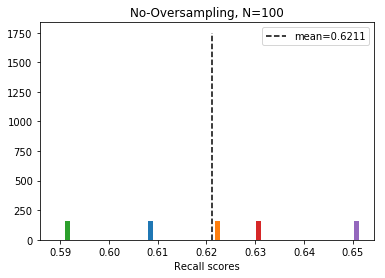

In [76]:
recall_scoresnp = np.array(recall_scores)
mean = np.mean(recall_scoresnp[:,1])
plt.hist(recall_scoresnp[:,1],density=True)
plt.plot([mean,mean],[0,1750],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("No-Oversampling, N=100")
plt.xlabel('Recall scores')

## With oversampling

In [26]:
labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare']
tran8 = tran.copy()
tran8.loc[~tran8.Class.isin(labels), ['Class']] = 'Other'
ntran8 = ntran.copy()




all8 = pd.concat([tran8,ntran8])

def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient']
    return labels.index(lab)

all8['target'] = list(map(lambda x: manualFact(x),all8['Class']))


oversampling = all8.copy()
# oversampling = oversampling[oversampling.index.get_level_values('copy_num')==0]

oversampling = oversampling.sample(frac=1)

# oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

# oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [ ]:
recall_scores = []
iterations = 5
for i in range(iterations):
    print("\r"+"{:.2f}%".format(i*100/iterations), end = "")
    
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    
    #balance the train set
    all_train= balance(all_train)
    
   

    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()
   
    #remove originals that may have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]
    
    #balance test
    all_test= balance(all_test)
    
    #format stuff
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')
    
    model,params = rf()
    grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                               refit='f1_score', return_train_score=True,verbose=100)
    grid_search.fit(all_train[feats], all_train.target)
    # Copy classifier
    clf = grid_search
    
#     clf = RandomForestClassifier(n_estimators=200,random_state=0, class_weight='balanced')
#     clf.fit(all_train[feats], all_train.target)

#     print(type(all_test.target.unique()[0]))
#     print(type(np.unique(clf.predict(all_test[feats]))[0]))
#     recall_scores.append(recall_score(all_test.target,clf.predict(all_test[feats]).astype(int)))

    scores = precision_recall_fscore_support(
            all_test.target, clf.predict(all_test[feats]), average='weighted')
    print(['-']*30)
    print(scores)
    print(['-']*30)
    
#     print(scores)
    recall_scores.append(scores)

0.00%Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.7736013986013986, precision=0.7713425463789852, recall=0.7736013986013986, f1_score=0.7717553690637193, total=   5.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.7835081585081585, precision=0.7840669095175818, recall=0.7835081585081585, f1_score=0.7827749929533564, total=   5.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.7778263403263403, precision=0.7762563112303573, recall=0.7778263403263403, f1_score=0.7762505421844215, total=  19.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | el

In [ ]:
recall_scores

In [ ]:
prin(recall_scores[:,0])

Text(0.5,0,'Recall scores')

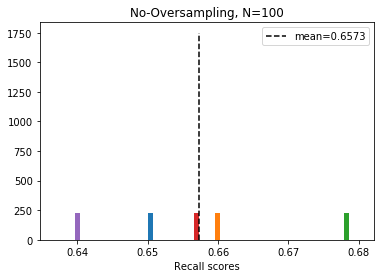

In [79]:
recall_scoresnp = np.array(recall_scores)
mean = np.mean(recall_scoresnp[:,1])
plt.hist(recall_scoresnp[:,1],density=True)
plt.plot([mean,mean],[0,1750],c='black',linestyle='--',label='mean={:.4f}'.format(mean))
plt.legend()
plt.title("No-Oversampling, N=100")
plt.xlabel('Recall scores')